In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
import os
import random
import numpy as np
import pandas as pd
from pandas import DataFrame
import cPickle as pickle
import math
import copy

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
with open('../data/state_features.txt') as f:
    state_features = f.read().split()
print (state_features)
print len(state_features)

['Albumin', 'Arterial_BE', 'Arterial_lactate', 'Arterial_pH', 'BUN', 'CO2_mEqL', 'Calcium', 'Chloride', 'Creatinine', 'DiaBP', 'FiO2_1', 'GCS', 'Glucose', 'HCO3', 'HR', 'Hb', 'INR', 'Ionised_Ca', 'Magnesium', 'MeanBP', 'PT', 'PTT', 'PaO2_FiO2', 'Platelets_count', 'Potassium', 'RR', 'SGOT', 'SGPT', 'SIRS', 'SOFA', 'Shock_Index', 'Sodium', 'SpO2', 'SysBP', 'Temp_C', 'Total_bili', 'WBC_count', 'Weight_kg', 'age', 'elixhauser', 'gender', 'mechvent', 'output_4hourly', 'output_total', 'paCO2', 'paO2', 're_admission', 'bloc']
48


In [4]:
chosen ardf = pd.read_csv('../data/rl_train_data_final_cont.csv')

In [5]:
df.head()

,bloc,icustayid,charttime,gender,age,elixhauser,re_admission,died_in_hosp,mortality_90d,Weight_kg,...,median_dose_vaso,max_dose_vaso,input_total_tev,input_4hourly_tev,output_total,output_4hourly,cumulated_balance_tev,vaso_input,iv_input,reward
0,0.000000,3,7245052800,0.0,0.412568,0.0,0.0,0,1,0.262712,...,0.0,0.0,0.797351,0.939195,0.589916,0.750908,0.554500,0.0,4.0,0.125000
1,0.222560,3,7245067200,0.0,0.412568,0.0,0.0,0,1,0.262712,...,0.0,0.0,0.831780,0.934543,0.674384,0.819589,0.580033,0.0,4.0,0.657321
2,0.356608,3,7245081600,0.0,0.412568,0.0,0.0,0,1,0.262712,...,0.0,0.0,0.833222,0.656575,0.765423,0.939329,0.555033,0.0,2.0,1.367788
3,0.452837,3,7245096000,0.0,0.412568,0.0,0.0,0,1,0.262712,...,0.0,0.0,0.834033,0.603831,0.783597,0.847073,0.545700,0.0,2.0,1.199099
4,0.527957,3,7245110400,0.0,0.412568,0.0,0.0,0,1,0.262712,...,0.0,0.0,0.834836,0.603831,0.794059,0.811583,0.539533,0.0,2.0,1.057596


In [6]:
val_df = pd.read_csv('../data/rl_val_data_final_cont.csv')

In [7]:
test_df = pd.read_csv('../data/rl_test_data_final_cont.csv')

In [8]:
# define an action mapping - how to get an id representing the action from the (iv,vaso) tuple
action_map = {}
count = 0
for iv in range(5):
    for vaso in range(5):
        action_map[(iv,vaso)] = count
        count += 1

In [9]:
inv_action_map = {}
for iv in range(5):
    for vaso in range(5):
        inv_action_map[5*iv+vaso] = [iv,vaso]    

In [10]:
chosen ar# Extract features (state vector) and labels (action taken) out of the dataframe for train 
# and val sets
def preproc(df_in, iv_bins = 5):
    df = df_in.copy()
    actions_raw = df[['iv_input', 'vaso_input']].values
    keep_arr = np.loadtxt('../data/state_features.txt', dtype=str)
    df = df[keep_arr]
    actions_proc = (iv_bins*actions_raw[:, 0] + actions_raw[:, 1]).astype(int)
    hist = np.histogram(actions_proc, 25)
    actions_proc = pd.get_dummies(actions_proc).values
    #print(hist) just to check
    return df.values, actions_proc

In [11]:
def batch_sample(batch_size, features, labels):
    idx = np.random.choice(np.arange(len(features)), batch_size)
    return (np.vstack(features[idx]), np.vstack(labels[idx]))

In [12]:
train_feat, train_labels = preproc(df)
val_feat, val_labels = preproc(val_df)
test_feat, test_labels = preproc(test_df)

In [13]:
feature_length = len(train_feat[0])
batch_size = 64
num_actions = 25
num_steps = 35000
num_mix_comp = 5
# we learn parameters for each of the mix components and the mixing probabilities
num_outputs = num_actions*num_mix_comp + num_mix_comp

In [20]:
class MDN():
    def __init__(self):
        self.input_feat = tf.placeholder(tf.float32, shape = [None, feature_length])
        
        self.actions = tf.placeholder(tf.float32, shape = [None, num_actions])
        
        self.phase = tf.placeholder(tf.bool)
        
        self.fc_1 = tf.contrib.layers.fully_connected(self.input_feat, 128, activation_fn=tf.nn.relu)
        self.bn_1 = tf.contrib.layers.batch_norm(self.fc_1, center=True, scale=True, is_training=self.phase)
        self.fc_2 = tf.contrib.layers.fully_connected(self.bn_1 , 128, activation_fn=tf.nn.relu)
        self.bn_2 = tf.contrib.layers.batch_norm(self.fc_2, center=True, scale=True, is_training=self.phase)
        
        self.prob_params = tf.contrib.layers.fully_connected(self.bn_2 , num_outputs, activation_fn=None)
        
        # from prob params, we estimate the different mixture components
        # Define: the first num_mix_comps of self.prob_params to be the mix probabilities
        # split the rest num_mix_comp ways to define the multinomial distns over actions
        self.unnorm_mix_prob, self.unnorm_multi_params = tf.split(self.prob_params, [num_mix_comp, num_actions*num_mix_comp], 1)
        
        # Reshape second value into [-1, 5, 25]
        self.unnorm_multi_params = tf.reshape(self.unnorm_multi_params, [-1, num_mix_comp, num_actions])
        
        # perform softmaxes
        self.mix_prob = tf.nn.softmax(self.unnorm_mix_prob)
        
        self.multi_params = tf.nn.softmax(self.unnorm_multi_params, dim=-1)
        
        # generate p(a, z | s) for analysis
        #Firstly tile the mix probabilites. Currently it's of shape (bs, num_mix_comps). Convert to (bs, num_mix, num_act)
        self.expanded_mix_prob = tf.tile(tf.expand_dims(self.mix_prob, axis=2), [1, 1, num_actions])
        
        self.joint_prob = self.expanded_mix_prob * self.multi_params
        
        # generate p(a_vec|s) by summing out 1 dimension. a_vec is a vector of ALL actions.
        # should be of dimension (bs,num_actions)
        self.lik_as_vec = tf.reduce_sum(self.joint_prob, axis=1)
        
        # select the actions actually taken
        self.vec = tf.tile(tf.expand_dims(self.actions, axis=1), [1,num_mix_comp,1])           
        
        # this is batchsize*num_mix_comp*num_actions. Sum out the num_actions dimension to get
        # tensor of shape bs*num_mix_comp
        self.rel_probs = tf.reduce_sum(self.vec*self.multi_params, axis=2)    
        
        # form the log likelihood
        # sum over batch (log ( sum over components(mixture prob * prob of action)))
        self.likelihood = tf.reduce_sum(self.rel_probs*self.mix_prob, axis=1)
    
        self.log_lik =  tf.reduce_sum(tf.log(self.likelihood))
        self.neg_log_lik = -1 * self.log_lik
        
        self.reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        self.reg_constant = 1
        
        self.update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(self.update_ops):
            self.train_step = tf.train.AdamOptimizer().minimize(self.neg_log_lik + self.reg_constant*tf.reduce_sum(self.reg_losses))

In [21]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # Don't use all GPUs 
config.allow_soft_placement = True  # Enable manual control

In [26]:
def get_probs_for_analysis(dataset, sess, mdn):
    # get p(a_vec| s) for each entry in dataset -- this sums over the mixture components
    # get p(a_vec| s, z^(k)) for each entry in the dataset for each mix component -- 3D tensor
    if dataset == 'train':
        features, labels = train_feat,train_labels
    elif dataset == 'val':
        features, labels = val_feat,val_labels
    elif dataset == 'test':
        features, labels = test_feat,test_labels
    
    j = 0
    
    marginal_lik_vec = []
    conditional_lik_vec = []
    
    while (j < len(features)):
        feat = None
        lbls = None
        if len(features) - j < batch_size:
            feat = features[j:]
            lbls = labels[j:]
        else:
            feat = features[j:j+batch_size]
            lbls = labels[j:j+batch_size]
        feat = feat.reshape(len(feat), feature_length)
        acs = lbls.reshape(len(lbls), num_actions)
        if j % 10000 == 0: 
            print('Processing indx: ', j )
        
        batch_marg_lik_vec, batch_cond_lik_vec = sess.run([mdn.lik_as_vec, mdn.multi_params], 
                          feed_dict={mdn.input_feat : feat, mdn.actions: acs, mdn.phase: 0})
        
        marginal_lik_vec.append(batch_marg_lik_vec)
        conditional_lik_vec.append(batch_cond_lik_vec)
        
        if len(features) - j < batch_size:
            j = len(features)
        else:
            j += batch_size
    
    marginal_lik_vec = np.vstack([arr for arr in marginal_lik_vec])
    conditional_lik_vec = np.vstack([arr for arr in conditional_lik_vec])
    return marginal_lik_vec, conditional_lik_vec

In [27]:
# Runs eval step
def run_eval(dataset,sess, mdn):
    if dataset == 'train':
        features, labels = train_feat,train_labels
    elif dataset == 'val':
        features, labels = val_feat,val_labels
    elif dataset == 'test':
        features, labels = test_feat,test_labels

    total_loss = 0
    j = 0
    while (j < len(features)):
        feat = None
        lbls = None
        if len(features) - j < batch_size:
            feat = features[j:-1]
            lbls = labels[j:-1]
        else:
            feat = features[j:j+batch_size]
            lbls = labels[j:j+batch_size]
        feat = feat.reshape(len(feat), feature_length)
        acs = lbls.reshape(len(lbls), num_actions)
        if j % 10000 == 0: 
            print('Processing val set indx: ', j )
        neg_log_lik = sess.run(mdn.neg_log_lik, 
                          feed_dict={mdn.input_feat : feat, mdn.actions: acs, mdn.phase: 0})
        total_loss += neg_log_lik
        if len(features) - j < batch_size:
            j = len(features)
        else:
            j += batch_size
    return total_loss
    

In [32]:
# The main training loop is here
num_steps = 80000 # How many steps to train for
load_model = False #Whether to load a saved model.
save_dir = "./mix_density/"
save_path = "./mix_density/ckpt"#The path to save our model to
tf.reset_default_graph()
mdn = MDN()
do_analysis = False

saver = tf.train.Saver(tf.global_variables())

init = tf.global_variables_initializer()

trainables = tf.trainable_variables()

#Make a path for our model to be saved in.
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

with tf.Session(config=config) as sess:
    if load_model == True:
        print('Trying to load model...')
        try:
            restorer = tf.train.import_meta_graph(save_path + '.meta')
            restorer.restore(sess, tf.train.latest_checkpoint(save_dir))
            print "Model restored"
        except IOError:
            print "No previous model found, running default init"
            sess.run(init)
    else:
        print("Running default init")
        sess.run(init)
    print("Init done")    
    
    net_loss = 0.0
    for i in range(num_steps):
        
        if do_analysis:
            marginal_lik, cond_lik = get_probs_for_analysis('val', sess, mdn)
            break

        feat, labels = batch_sample(batch_size, train_feat, train_labels)
        _, neg_log_lik = sess.run([mdn.train_step, mdn.neg_log_lik], 
                                  feed_dict={mdn.input_feat : feat, mdn.actions: labels, mdn.phase: 1})
        net_loss += neg_log_lik
        if i > 0 and i % 1000 == 0:
            print "Loss in 1000 steps ", net_loss
            net_loss = 0
            saver.save(sess,save_path)
            print("Saved Model, step is " + str(i))
        
        if i % 5000 == 0 and i > 0:
            print "Test on validation set"
            val_loss = run_eval('val', sess, mdn)
            print('Val set loss: ', val_loss)      
    marginal_lik, cond_lik = get_probs_for_analysis('val', sess, mdn)

[<tf.Tensor 'gradients/split_grad/concat:0' shape=(?, 130) dtype=float32>, None, None]
Running default init
Init done
Loss in 1000 steps  123662.465744
Saved Model, step is 1000
Loss in 1000 steps  114372.749039
Saved Model, step is 2000
Loss in 1000 steps  111689.745827
Saved Model, step is 3000
Loss in 1000 steps  109818.189346
Saved Model, step is 4000
Loss in 1000 steps  108210.888313
Saved Model, step is 5000
Test on validation set
('Processing val set indx: ', 0)
('Val set loss: ', 44111.319297790527)
Loss in 1000 steps  106938.701454
Saved Model, step is 6000
Loss in 1000 steps  106197.24572
Saved Model, step is 7000
Loss in 1000 steps  105216.882782
Saved Model, step is 8000
Loss in 1000 steps  104549.128212
Saved Model, step is 9000
Loss in 1000 steps  103418.804359
Saved Model, step is 10000
Test on validation set
('Processing val set indx: ', 0)
('Val set loss: ', 43823.138320922852)
Loss in 1000 steps  103345.749596
Saved Model, step is 11000
Loss in 1000 steps  102803.8005

In [60]:
np.save('./mix_density/marginal_lik_val.npy', marginal_lik)
np.save('./mix_density/cond_lik_val.npy', cond_lik)

In [ ]:
# FIRSTLY, ARGMAX PLOTS

In [61]:
# get the argmaxes for the first analysis
actions_chosen = np.argmax(marginal_lik, axis=1)
val_labels_asvec = np.argmax(val_labels, axis=1)
mix_actions_chosen = np.argmax(cond_lik, axis=2)

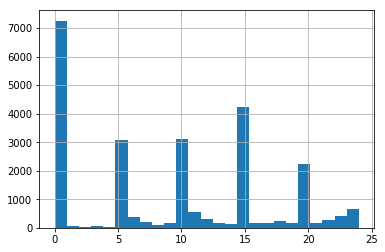

In [62]:
pd.Series(actions_chosen).hist(bins=25)

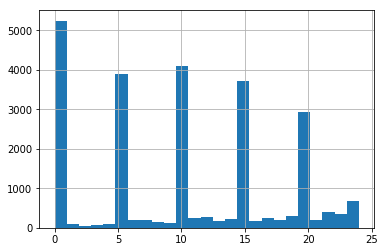

In [63]:
pd.Series(val_labels_asvec).hist(bins=25)

6366


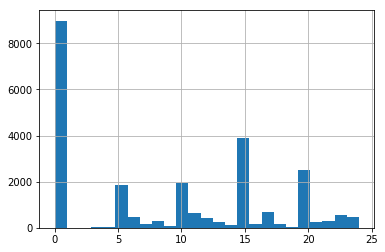

5222


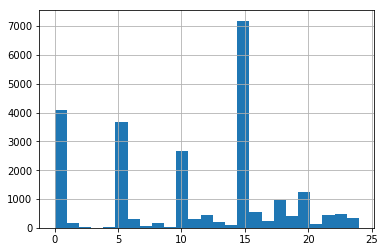

5827


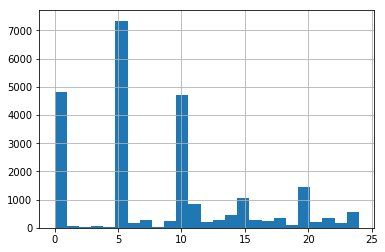

7075


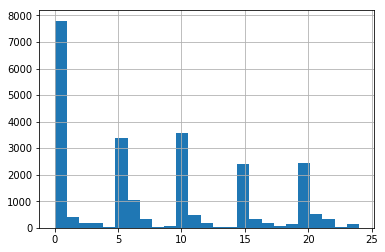

6119


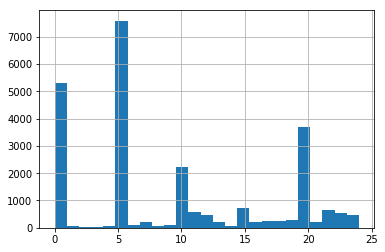

In [64]:
for i in range(num_mix_comp):
    pd.Series(mix_actions_chosen[:,i]).hist(bins=25)
    print sum(mix_actions_chosen[:,i] == val_labels_asvec)
    plt.show()

In [71]:
# get the means for the second analysis
ml_mean = np.mean(marginal_lik, axis=0)
cl_mean = np.mean(cond_lik, axis=0)

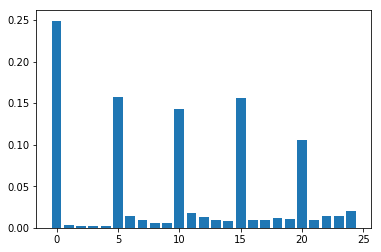

In [73]:
_ = plt.bar(range(25), ml_mean)

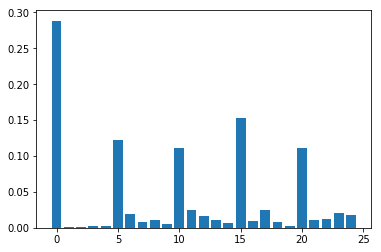

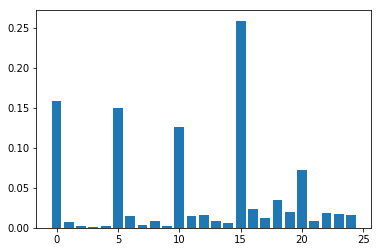

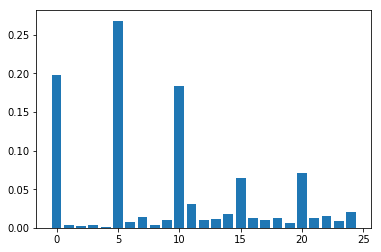

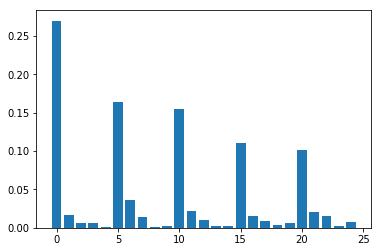

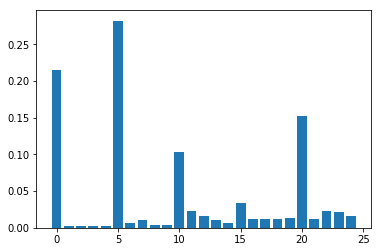

In [74]:
for i in range(num_mix_comp):
    _ = plt.bar(range(25), cl_mean[i,:])
    plt.show()

In [89]:
# the ones above are for all patients.
# Now consider when we stratify by severity -- select entries that have SOFA scores in certain ranges
# consider the argmax actions
df_orig = pd.read_csv('../data/MKdataset07Feb17.csv')
df_orig_val = df_orig.loc[df_orig['icustayid'].isin(val_df['icustayid'].unique())]
del df_orig

In [91]:
low_sofa = np.array(df_orig_val['SOFA'] <= 5)
med_sofa = np.array(df_orig_val['SOFA'] > 5)
med_sofa[(df_orig_val['SOFA']) > 15] = False
high_sofa = np.array(df_orig_val['SOFA'] > 15)

In [96]:
# get the means for the third analysis for all three regimes
ml_mean_lowsofa = np.mean(marginal_lik[low_sofa], axis=0)
cl_mean_lowsofa= np.mean(cond_lik[low_sofa], axis=0)

ml_mean_medsofa = np.mean(marginal_lik[med_sofa], axis=0)
cl_mean_medsofa= np.mean(cond_lik[med_sofa], axis=0)

ml_mean_highsofa = np.mean(marginal_lik[high_sofa], axis=0)
cl_mean_highsofa= np.mean(cond_lik[high_sofa], axis=0)

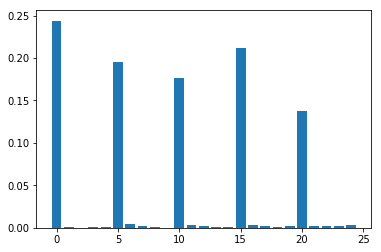

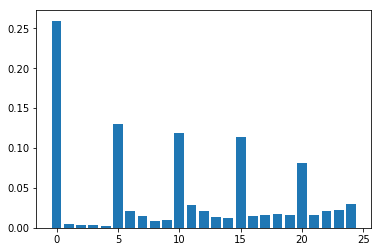

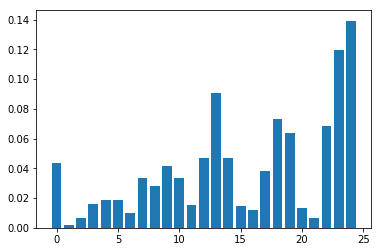

In [98]:
for m in [ml_mean_lowsofa, ml_mean_medsofa, ml_mean_highsofa]:
    _ = plt.bar(range(25), m)
    plt.show()

LOW SOFA


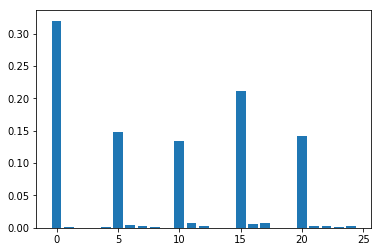

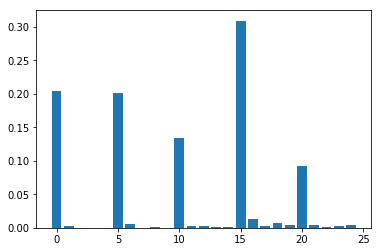

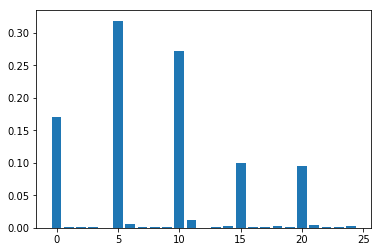

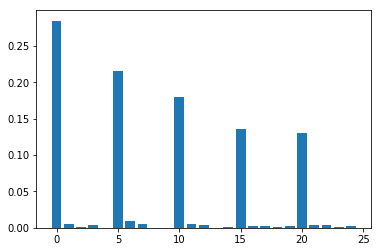

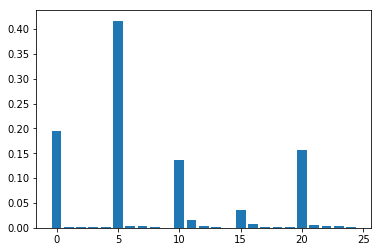

MED SOFA


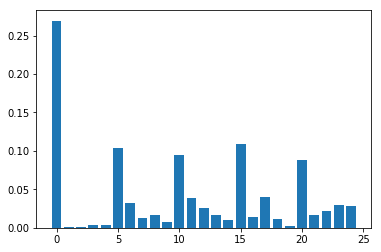

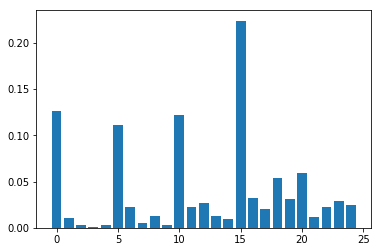

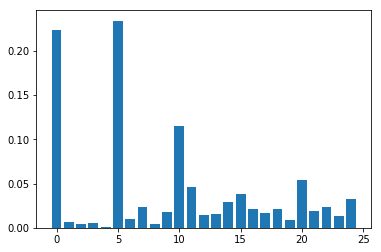

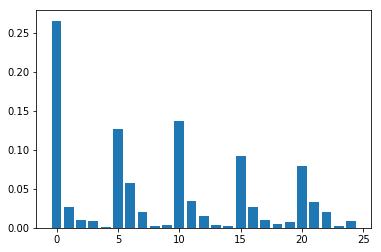

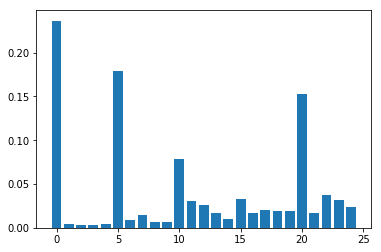

HIGH SOFA


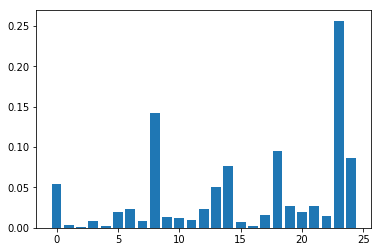

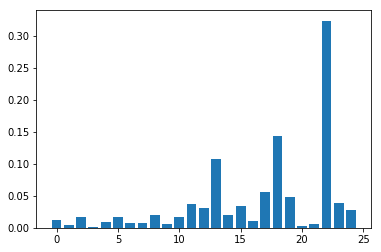

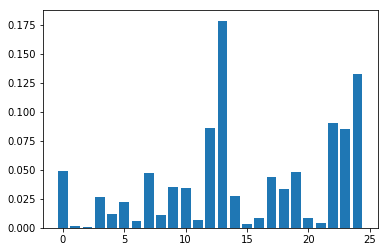

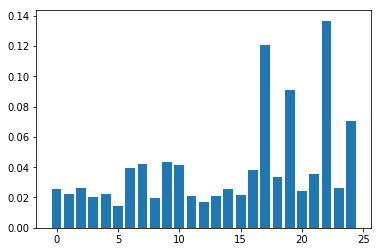

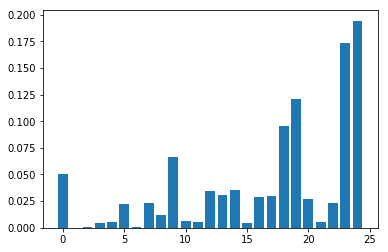

In [100]:
for ind, c in enumerate([cl_mean_lowsofa, cl_mean_medsofa, cl_mean_highsofa]):
    if ind == 0:
        print "LOW SOFA"
    elif ind == 1:
        print "MED SOFA"
    elif ind == 2:
        print "HIGH SOFA"
    for i in range(num_mix_comp):
        _ = plt.bar(range(25), c[i,:])
        plt.show()